 # Quantium Data Analytics Virtual Experience - Task2 - Josh Bryden

In [1]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind, t

#Pandas settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# seaborn settings
sns.set_style("darkgrid")


 ## Data importing

In [2]:
chips_data = pd.read_csv('../data/chips_data.csv')
chips_data.head()


,Unnamed: 0,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,LIFESTAGE,PREMIUM_CUSTOMER,PACK_WEIGHT,BRAND_NAME,AVG_CHIP_PRICE
0,0,2018-10-17,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0,YOUNG SINGLES/COUPLES,Premium,175,Natural Chip Co,3.00
1,1,2019-05-14,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3,MIDAGE SINGLES/COUPLES,Budget,175,CCs,2.10
2,2,2019-05-20,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9,MIDAGE SINGLES/COUPLES,Budget,170,Smiths,1.45
3,3,2018-08-17,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,5,15.0,MIDAGE SINGLES/COUPLES,Budget,175,Smiths,3.00
4,4,2018-08-18,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3,13.8,MIDAGE SINGLES/COUPLES,Budget,150,Kettle,4.60


 ## Data cleaning

In [3]:
# Checking that all our data in encoded correctly
chips_data.dtypes


Unnamed: 0            int64
DATE                 object
STORE_NBR             int64
LYLTY_CARD_NBR        int64
TXN_ID                int64
PROD_NBR              int64
PROD_NAME            object
PROD_QTY              int64
TOT_SALES           float64
LIFESTAGE            object
PREMIUM_CUSTOMER     object
PACK_WEIGHT           int64
BRAND_NAME           object
AVG_CHIP_PRICE      float64
dtype: object

In [4]:
# Date is encoded as object - change to datetime
chips_data['DATE'] = pd.to_datetime(chips_data['DATE'])


In [5]:
 # Create column YEAR_MONTH to store year and month from the date
chips_data['YEAR_MONTH'] = chips_data['DATE'].dt.strftime('%Y%m').astype('int')
chips_data.head()


,Unnamed: 0,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,LIFESTAGE,PREMIUM_CUSTOMER,PACK_WEIGHT,BRAND_NAME,AVG_CHIP_PRICE,YEAR_MONTH
0,0,2018-10-17,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0,YOUNG SINGLES/COUPLES,Premium,175,Natural Chip Co,3.00,201810
1,1,2019-05-14,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3,MIDAGE SINGLES/COUPLES,Budget,175,CCs,2.10,201905
2,2,2019-05-20,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9,MIDAGE SINGLES/COUPLES,Budget,170,Smiths,1.45,201905
3,3,2018-08-17,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,5,15.0,MIDAGE SINGLES/COUPLES,Budget,175,Smiths,3.00,201808
4,4,2018-08-18,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3,13.8,MIDAGE SINGLES/COUPLES,Budget,150,Kettle,4.60,201808


In [6]:
# Task asks us to select control stores
# Trial stores are store numbers: 77, 86 and 88
# Hence we need stores that match these trial stores in terms of:

#           - Same sales
#           - Same num of customers
#           - Same transaction numbers

# Group stores by STORE_NBR and YEAR_MONTH - showing:
#           - sum of sales - $
#           - unique loyal card numbers - num of customers
#           - unique transaction id - num of transactions
#           - sum of product qty - product sold

store_selection = chips_data.groupby(['STORE_NBR','YEAR_MONTH']).agg(
                {'TOT_SALES': 'sum', 'LYLTY_CARD_NBR': 'nunique',
                 'TXN_ID': 'nunique', 'PROD_QTY': 'sum'})

# Create UNIT_PRICE column for unit price of chips
store_selection['AVG_UNIT_PRICE'] = (store_selection['TOT_SALES']/
                                store_selection['PROD_QTY'])

# Transactions per customer
store_selection['TXN_PER_LOYALTY_CARD_NUM'] = (store_selection['TXN_ID']/
                                            store_selection['LYLTY_CARD_NBR'])

# Reset index
store_selection = store_selection.reset_index()
store_selection.head()


,STORE_NBR,YEAR_MONTH,TOT_SALES,LYLTY_CARD_NBR,TXN_ID,PROD_QTY,AVG_UNIT_PRICE,TXN_PER_LOYALTY_CARD_NUM
0,1,201807,188.9,47,49,58,3.256897,1.042553
1,1,201808,168.4,41,41,52,3.238462,1.000000
2,1,201809,268.1,57,59,71,3.776056,1.035088
3,1,201810,175.4,39,40,51,3.439216,1.025641
4,1,201811,184.8,44,45,55,3.360000,1.022727


In [7]:
# Trial period start of Feb 19 - end of April 19
# Count num of times a store num appears (ie how many months of data)
stores_12_months = store_selection['STORE_NBR'].value_counts()
# Filter by stores with 12 months of data - store as index
stores_12_months = stores_12_months[stores_12_months == 12].index
# Filter index stores to store_selection df and map by store number
stores_12_months = (store_selection[store_selection['STORE_NBR']
                    .isin(stores_12_months)])
# Filter for data before the trial begun
pre_trial_stores = stores_12_months[stores_12_months['YEAR_MONTH']<201902]


In [8]:
# Correlation between trial and control stores based on chip sales

# Define function to calculate correlation
def storeCorr(metric_columns, trial_store_num, pre_trial_stores=pre_trial_stores):

        """ Function calculates correction between stores

        Args:
            metric_columns ([list]): [columns to compare]
            trial_store_num ([int]): [store number of trial store]
            pre_trial_stores ([df], optional): [df of stores before 201902 with 12 months of data]. 
                                                Defaults to pre_trial_stores.

        Returns:
            [correlation]: [df of the correlation between the trial store and
                                control stores]
        """

        # Extract control stores by taking inverse of the df where trial stores are (by store num)
        control_store_num = (pre_trial_stores[~pre_trial_stores['STORE_NBR'].isin([77,86.88])]['STORE_NBR'].unique())
        # Create df with desired column names to store correlation
        correlation = pd.DataFrame(columns=['YEAR_MONTH', 'TRIAL_STORE',
                                         'CONTROL_STORE', 'CORR'])
        # Extract the trial stores from the input table
        trial_stores = pre_trial_stores[pre_trial_stores['STORE_NBR']==trial_store_num][metric_columns].reset_index()
        # Loop over the control stores
        for store in control_store_num:
                df = pd.DataFrame(columns= ['YEAR_MONTH', 'TRIAL_STORE', 'CONTROL_STORE','CORR'])
                # For each control store num extract all rows for that particular store
                control_store = pre_trial_stores[pre_trial_stores['STORE_NBR']== store][metric_columns].reset_index()
                # Assign CORR column to the correlation with each trial store to new df
                # (a row for each month and hence correlation for that month)
                df['CORR'] = trial_stores.corrwith(control_store, axis=1)
                # Assign the trial store num to new df
                df['TRIAL_STORE'] = trial_store_num
                # Assign the control store num to the df (a row for each month and hence correlation for that month)
                df['CONTROL_STORE'] = store
                # Assign the year and month for the correlation based off the current input table row
                df['YEAR_MONTH'] = list(pre_trial_stores[pre_trial_stores['STORE_NBR']== trial_store_num]['YEAR_MONTH'])
                # Combine the new df to our master correlation df 
                correlation = pd.concat([correlation, df])
        return correlation


In [9]:
# Create blank df for correlation
correlation_table = pd.DataFrame()
# Loop over each trial store
for trial_store in [77,86,88]:
    # For each trial store combine our df with the storeCorr function on selected columns
    correlation_table = pd.concat([correlation_table, storeCorr(['TOT_SALES',
                                                         'LYLTY_CARD_NBR',
                                                         'TXN_ID',
                                                         'TXN_PER_LOYALTY_CARD_NUM',
                                                         'AVG_UNIT_PRICE'], trial_store)])
correlation_table.head()
                                                    

,YEAR_MONTH,TRIAL_STORE,CONTROL_STORE,CORR
0,201807,77,1,-0.039076
1,201808,77,1,-0.052667
2,201809,77,1,-0.070637
3,201810,77,1,-0.093093
4,201811,77,1,-0.061226


In [10]:
# Create function to compute magnitude distance
def store_magnitude (metric_columns, trial_store_num, pre_trial_stores=pre_trial_stores):
        """ Function calculates magnitude between stores

        Args:
            metric_columns ([list]): [columns to compare]
            trial_store_num ([int]): [store number of trial store]
            pre_trial_stores ([df], optional): [df of stores before 201902 with 12 months of data]. 
                                                Defaults to pre_trial_stores.

        Returns: 
            [magnitude]: [df of the magnitude between the trial store and
                                control stores]
        """
        # Extract control stores by taking inverse of the df where trial stores are (by store num)
        control_store_num = (pre_trial_stores[~pre_trial_stores['STORE_NBR']
                                .isin([77,86,88])]['STORE_NBR'].unique())
        # Initialize empty df
        magnitude = pd.DataFrame()
        # Extract the trial stores from the input table
        trial_stores = pre_trial_stores[pre_trial_stores['STORE_NBR']== trial_store_num][metric_columns]
        # Loop over the control stores
        for store in control_store_num:
        # Take absolute value of: (trial store metric columns of interest minus (-) the control store metric columns 
                df = abs(pre_trial_stores[pre_trial_stores['STORE_NBR']== trial_store_num].reset_index()[metric_columns]
                        - pre_trial_stores[pre_trial_stores['STORE_NBR']==store].reset_index()[metric_columns])
        # Assign the trial store num to new df
                df['TRIAL_STORE'] = trial_store_num
        # Assign the control store num to the df (a row for each month and hence magnitude for that month)
                df['CONTROL_STORE'] = store
        # Assign the year and month for the magnitude based off the current input table row
                df['YEAR_MONTH'] = list(pre_trial_stores[pre_trial_stores['STORE_NBR']== trial_store_num]['YEAR_MONTH'])
        # Concat the two df together
                magnitude = pd.concat([magnitude, df])
        # Loop over each column of interest
        for column in metric_columns:
        # Compute the magnitude:
        # 1- (Observed distance – minimum distance)/(Maximum distance – minimum distance)
                magnitude[column] = 1 - ((magnitude[column] - magnitude[column].min()) /
                                        (magnitude[column].max() - magnitude[column].min()))
        # Assign the mean value of the metric_columns for each store to a new column called magnitude
        magnitude['MAGNITUDE'] = magnitude[metric_columns].mean(axis=1)
        # Return the df
        return magnitude


In [11]:
# Create blank df for magnitude
magnitude = pd.DataFrame()
# Loop over each trial store
for trial_store in [77,86,88]:
    # For each trial store combine our df with the store_magnitude function on selected columns
    magnitude = pd.concat([magnitude, store_magnitude(['TOT_SALES',
                                                         'LYLTY_CARD_NBR',
                                                         'TXN_ID',
                                                         'TXN_PER_LOYALTY_CARD_NUM',
                                                         'AVG_UNIT_PRICE'], trial_store)])
magnitude.head()


,TOT_SALES,LYLTY_CARD_NBR,TXN_ID,TXN_PER_LOYALTY_CARD_NUM,AVG_UNIT_PRICE,TRIAL_STORE,CONTROL_STORE,YEAR_MONTH,MAGNITUDE
0,0.939141,1.000000,0.985185,0.910742,0.853885,77,1,201807,0.937791
1,0.939447,0.950495,0.962963,1.000000,0.841984,77,1,201808,0.938978
2,0.960729,0.831683,0.874074,0.968721,0.686332,77,1,201809,0.864308
3,0.985532,0.970297,0.977778,0.995518,0.714699,77,1,201810,0.928765
4,0.969303,0.950495,0.977778,0.886321,0.866003,77,1,201811,0.929980


In [12]:
# Combine both the correlation and magnitude columns
def combine_mag_corr(metric_columns, trial_store_num, pre_trial_stores=pre_trial_stores):
        """ Function combines magnitude and correlation between stores

        Args:
            metric_columns ([list]): [columns to compare]
            trial_store_num ([int]): [store number of trial store]
            pre_trial_stores ([df], optional): [df of stores before 201902 with 12 months of data]. 
                                                Defaults to pre_trial_stores.

        Returns: 
            [master]: [df of both the magnitude and correlation between the trial store and
                                control stores]
        """
        # Compute correlation with storeCorr function
        correlation = storeCorr(metric_columns, trial_store_num, pre_trial_stores)
        # Compute magnitude with store_magnitude function
        magnitude = store_magnitude(metric_columns, trial_store_num, pre_trial_stores)
        # Drop all rows except magnitude before combining 
        magnitude = magnitude.drop(metric_columns, axis=1)
        #
        master = pd.merge(correlation, magnitude, on=['CONTROL_STORE', 'TRIAL_STORE', 'YEAR_MONTH'])
        return master


In [13]:
# Compare stores based off total sales
master_sales = pd.DataFrame()
# Loop over trial stores
for trial_store in [77, 86, 88]:
        # Call combine_mag_corr
        master_sales = pd.concat([master_sales, combine_mag_corr(['TOT_SALES'], trial_store)])


In [14]:
# Group sales by trial and control stores and take mean
sales_compare = master_sales.groupby(['TRIAL_STORE', 'CONTROL_STORE']).mean().reset_index()
# Combine correlation and magnitude to obtain a new scoring method (0.5 weight for magnitude and 0.5 for correlation )
# This effectively takes each measure into equal consideration for analysis
sales_compare['master_score'] = (0.5*sales_compare['CORR']) + (0.5*sales_compare['MAGNITUDE'])
# For each trial store print the top store with the highest magnitude for total sales
for trial_store in [77, 86, 88]:
        # Prints stores with highest master_score based off TOT_SALES alone
        print(sales_compare[sales_compare['TRIAL_STORE']==trial_store].sort_values(
                                                                ascending=False, by='master_score').head())


     TRIAL_STORE  CONTROL_STORE  CORR  MAGNITUDE  master_score
217           77            233   1.0   0.986702      0.993351
176           77            188   1.0   0.980567      0.990283
120           77            131   1.0   0.977341      0.988670
238           77            255   1.0   0.976794      0.988397
192           77            205   1.0   0.976706      0.988353
     TRIAL_STORE  CONTROL_STORE  CORR  MAGNITUDE  master_score
400           86            155   1.0   0.964165      0.982082
355           86            109   1.0   0.955015      0.977507
383           86            138   1.0   0.950843      0.975421
362           86            116   1.0   0.950053      0.975027
449           86            207   1.0   0.949940      0.974970
     TRIAL_STORE  CONTROL_STORE  CORR  MAGNITUDE  master_score
549           88             40   1.0   0.933101      0.966550
515           88              4   1.0   0.911153      0.955577
536           88             26   1.0   0.907058      0

In [15]:
# Compare stores based off number of customers (loyalty card info)
master_customers = pd.DataFrame()
# Loop over trial stores
for trial_store in [77, 86, 88]:
        # Call combine_mag_corr
        master_customers = pd.concat([master_customers, combine_mag_corr(['LYLTY_CARD_NBR'], trial_store)])


In [16]:
# Group customers by trial and control stores and take mean
customer_compare = master_customers.groupby(['TRIAL_STORE', 'CONTROL_STORE']).mean().reset_index()
# Combine correlation and magnitude to obtain a new scoring method (0.5 weight for magnitude and 0.5 for correlation )
# This effectively takes each measure into equal consideration for analysis
customer_compare['master_score'] = (0.5*customer_compare['CORR']) + (0.5*customer_compare['MAGNITUDE'])
# For each trial store print the top store with the highest magnitude for total sales
for trial_store in [77, 86, 88]:
        # Prints stores with highest master_score based off LYLTY_CARD_NBR alone (num of customers)
        print(customer_compare[customer_compare['TRIAL_STORE']==trial_store].sort_values(
                                                        ascending=False, by='master_score').head())


     TRIAL_STORE  CONTROL_STORE  CORR  MAGNITUDE  master_score
217           77            233   1.0   0.991513      0.995757
38            77             41   1.0   0.961810      0.980905
15            77             17   1.0   0.960396      0.980198
42            77             46   1.0   0.960396      0.980198
134           77            145   1.0   0.957567      0.978784
     TRIAL_STORE  CONTROL_STORE  CORR  MAGNITUDE  master_score
400           86            155   1.0   0.975035      0.987517
465           86            225   1.0   0.968100      0.984050
360           86            114   1.0   0.959778      0.979889
355           86            109   1.0   0.951456      0.975728
428           86            184   1.0   0.951456      0.975728
     TRIAL_STORE  CONTROL_STORE  CORR  MAGNITUDE  master_score
733           88            237   1.0   0.979094      0.989547
549           88             40   1.0   0.939605      0.969803
698           88            199   1.0   0.938444      0

In [17]:
# Combine master scores for TOT_SALES and LYLTY_CARD_NBR to obtain control/ trial store pairs
# Loop over each trial store
for trial_store in [77, 86, 88]:
        # Set x to be where our sales match our trial stores the best by master score
        sales = (sales_compare[sales_compare['TRIAL_STORE']== trial_store].sort_values(ascending=False, by='master_score')
                .set_index(['TRIAL_STORE', 'CONTROL_STORE'])['master_score'])

        # Set y to be where our customer numbers match our trial stores the most by master score
        customers = (customer_compare[customer_compare['TRIAL_STORE']== trial_store].sort_values(ascending=False,
                 by='master_score').set_index(['TRIAL_STORE', 'CONTROL_STORE'])['master_score'])
        # Print and combine sales/customers taking the average of the master scores and print top 3 pairs (control/trial)
        print((pd.concat([sales,customers],axis=1).sum(axis=1)/2).sort_values(ascending=False).head(3))
# Prints out:

# TRIAL_STORE  CONTROL_STORE
# 77           233              0.994554
#              46               0.983852
#              188              0.981705
# dtype: float64
# TRIAL_STORE  CONTROL_STORE
# 86           155              0.984800
#              109              0.976618
#              225              0.975346
# dtype: float64
# TRIAL_STORE  CONTROL_STORE
# 88           40               0.968176
#              26               0.957020
#              58               0.953097
# dtype: float64


TRIAL_STORE  CONTROL_STORE
77           233              0.994554
             46               0.983852
             188              0.981705
dtype: float64
TRIAL_STORE  CONTROL_STORE
86           155              0.984800
             109              0.976618
             225              0.975346
dtype: float64
TRIAL_STORE  CONTROL_STORE
88           40               0.968176
             26               0.957020
             58               0.953097
dtype: float64


 ## Visualizations

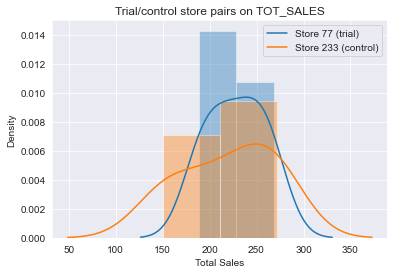

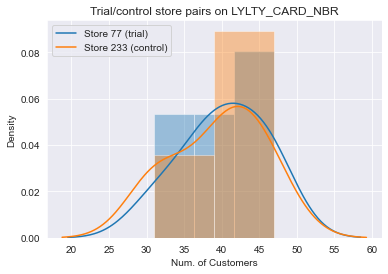

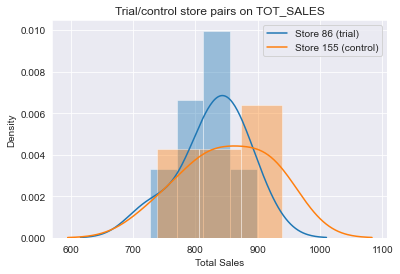

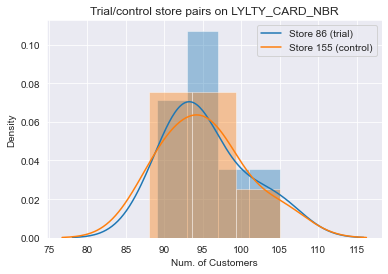

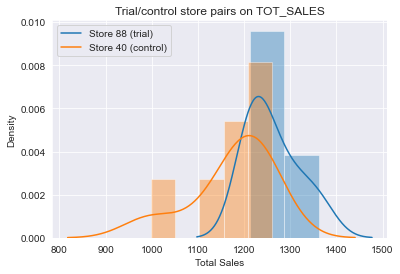

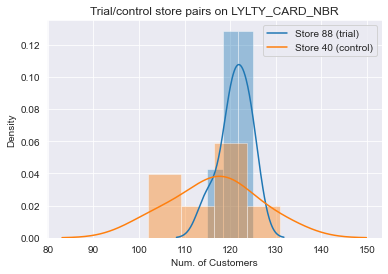

In [18]:

# Create dic of trial/ control pairs to loop over
trial_control_dic = {77:233, 86:155, 88:40}
# Loop over keys and values
for trial, control in trial_control_dic.items():
        # Create plot for TOT_SALES
        sns.distplot(pre_trial_stores.loc[pre_trial_stores['STORE_NBR']==trial]['TOT_SALES'])
        sns.distplot(pre_trial_stores.loc[pre_trial_stores['STORE_NBR']==control]['TOT_SALES'])
        plt.legend(labels=[f'Store {trial} (trial)', f'Store {control} (control)'])
        plt.title('Trial/control store pairs on TOT_SALES')
        plt.xlabel('Total Sales')
        plt.show()
        # Create plot for LYLTY_CARD_NBR (num of customers)
        sns.distplot(pre_trial_stores.loc[pre_trial_stores['STORE_NBR']==trial]['LYLTY_CARD_NBR'])
        sns.distplot(pre_trial_stores.loc[pre_trial_stores['STORE_NBR']==control]['LYLTY_CARD_NBR'])
        plt.legend(labels=[f'Store {trial} (trial)', f'Store {control} (control)'])
        plt.title('Trial/control store pairs on LYLTY_CARD_NBR')
        plt.xlabel('Num. of Customers')
        plt.show()


In [19]:
# To compare performance of trial stores, we need to scale all control store
# performance to trial store performance for the pre-trial period for the sum of TOT_SALES

# Scale TOT_SALES for store 77 and store 233
sales_scale_77 = (pre_trial_stores[pre_trial_stores['STORE_NBR']==77]['TOT_SALES'].sum()/
                        pre_trial_stores[pre_trial_stores['STORE_NBR']==233]['TOT_SALES'].sum())

# Scale TOT_SALES for store 86 and store 155
sales_scale_86 = (pre_trial_stores[pre_trial_stores['STORE_NBR']==86]['TOT_SALES'].sum()/
                        pre_trial_stores[pre_trial_stores['STORE_NBR']==155]['TOT_SALES'].sum())

# Scale TOT_SALES for store 88 and store 40
sales_scale_88 = (pre_trial_stores[pre_trial_stores['STORE_NBR']==88]['TOT_SALES'].sum()/
                        pre_trial_stores[pre_trial_stores['STORE_NBR']==40]['TOT_SALES'].sum())


In [20]:
# Filter for trial period dates
trial_period = stores_12_months[(stores_12_months['YEAR_MONTH']>=201902) & (stores_12_months['YEAR_MONTH']<=201904)]
# Filter for control stores on 'STORE_NBR', 'YEAR_MONTH', 'TOT_SALES'
scaled_store_sales = stores_12_months[stores_12_months['STORE_NBR'].isin([233,155,40])][['STORE_NBR', 'YEAR_MONTH',
                                                                                        'TOT_SALES']]

In [21]:
# Create function to scale sales data
def scale(store):
        """[Function scales trial and control store pretrial data]

        Args:
            store ([row of data]): [input is row of df for a particular store num]

        Returns:
            [scaled data]: [scaled pretrial store data]
        """
        if store['STORE_NBR'] ==233:
                return store['TOT_SALES'] * sales_scale_77
        elif store['STORE_NBR']==155:
                return store['TOT_SALES'] * sales_scale_86
        elif store['STORE_NBR']==40:
                return store['TOT_SALES'] * sales_scale_88


In [22]:
# Apply scale function and create new column
scaled_store_sales['SALES_SCALED'] = scaled_store_sales.apply(lambda store: scale(store), axis=1)
# Filter out trial store period
trial_period_scaled_sales = scaled_store_sales[(scaled_store_sales['YEAR_MONTH']>=201902) &
                                                 (scaled_store_sales['YEAR_MONTH']<=201904)]
# Filter out pre-trial scaled data
pretrial_scaled_sales = scaled_store_sales[scaled_store_sales['YEAR_MONTH']<201902]


In [23]:
# Null hypothesis that there is no difference between store pre-trial and trial period performance on sales
# Use ttest_ind to test for null hypoth that two samples have identical average values
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html
# Loop over each control store
for control_store in [233, 155, 40]:
        print(f'Store number: {control_store}')
        # Compute the t test statistic for the pretrial sales and the trial period sales for each control store
        print(ttest_ind(pretrial_scaled_sales[pretrial_scaled_sales['STORE_NBR']==control_store]['SALES_SCALED'],
                trial_period_scaled_sales[trial_period_scaled_sales['STORE_NBR']==control_store]['SALES_SCALED']))

# Outputs:

# Store number: 233
# Ttest_indResult(statistic=1.1432469352201307, pvalue=0.2859919469281543)

# Store number: 155
# Ttest_indResult(statistic=1.0217889604585213, pvalue=0.33678271820066796)

# Store number: 40
# Ttest_indResult(statistic=-0.30265739096672245, pvalue=0.7698710330791956)

# Null hypothesis is true - no significant difference between control store pre-trial and trial sales


Store number: 233
Ttest_indResult(statistic=1.1432469352201307, pvalue=0.2859919469281543)
Store number: 155
Ttest_indResult(statistic=1.0217889604585213, pvalue=0.33678271820066796)
Store number: 40
Ttest_indResult(statistic=-0.30265739096672245, pvalue=0.7698710330791956)


In [24]:
# Compute percentage difference in scaled sales
# Sort control store sales and drop TOT_SALES
x = scaled_store_sales.sort_values(by=["STORE_NBR", "YEAR_MONTH"], ascending=[False, True]).reset_index().drop(["TOT_SALES", "index"], axis=1)
# Sort trial store sales and drop YEAR_MONTH
y = stores_12_months[stores_12_months["STORE_NBR"].isin([77,86,88])][["STORE_NBR", "YEAR_MONTH", "TOT_SALES"]].reset_index().drop(["index", "YEAR_MONTH"], axis=1)
# Combine the two
scaled_sales_percent_diff = pd.concat([x, y], axis=1)
# Rename columns for control/trial
scaled_sales_percent_diff.columns = ["control_STORE_NBR", "YEAR_MONTH", "control_ScaledSales", "trial_STORE_NBR", "trial_TOT_SALES"]
# Compute percent diff in sales
scaled_sales_percent_diff["sales_percent_diff"] = (scaled_sales_percent_diff["trial_TOT_SALES"] - scaled_sales_percent_diff["control_ScaledSales"]) / (((scaled_sales_percent_diff["trial_TOT_SALES"] + scaled_sales_percent_diff["control_ScaledSales"])/2))

# For ease - create function to compute new column for pre-trial, trial and post trial times
def period(store):
    if store < 201902:
        return "Pre"
    elif store > 201904:
        return "Post"
    else:
        return "Trial"
# Apply function to our df
scaled_sales_percent_diff["trial_period"] = scaled_sales_percent_diff["YEAR_MONTH"].apply(lambda store: period(store))
# Delete our temporary df for memory optimization 
del x,y 


In [25]:
# Null hypothesis that no difference between trial store and control store pre-trial sales
for trial_store, control_store in trial_control_dic.items():
        print(f'Trial store: {trial_store}', f'Control store: {control_store}')
        print(ttest_ind(pre_trial_stores[pre_trial_stores['STORE_NBR']==trial_store]['TOT_SALES'],
                pretrial_scaled_sales[pretrial_scaled_sales['STORE_NBR']==control]['SALES_SCALED']))

# Outputs:

# Trial store: 77 Control store: 233
# Ttest_indResult(statistic=-27.435316685994458, pvalue=3.391608962966685e-12)

# Trial store: 86 Control store: 155
# Ttest_indResult(statistic=-10.472171690553463, pvalue=2.1706255444373868e-07)

# Trial store: 88 Control store: 40
# Ttest_indResult(statistic=-5.438369418905365e-15, pvalue=0.9999999999999958)

# Null hypothesis is true - no significant difference between trial store sales and control store scaled sales pre-trial

Trial store: 77 Control store: 233
Ttest_indResult(statistic=-27.435316685994458, pvalue=3.391608962966685e-12)
Trial store: 86 Control store: 155
Ttest_indResult(statistic=-10.472171690553463, pvalue=2.1706255444373868e-07)
Trial store: 88 Control store: 40
Ttest_indResult(statistic=-5.438369418905365e-15, pvalue=0.9999999999999958)


In [26]:
# Null hypothesis that percent diff in sales between trial and control stores pre-trial
#  is the same as during the trial - hence no difference in sales from the trial
for trial_store, control_store in trial_control_dic.items():
        print(f'Trial store: {trial_store}', f'Control store: {control_store}')
        # Select where control stores sales were pre-trial
        x = scaled_sales_percent_diff[(scaled_sales_percent_diff['control_STORE_NBR']==control_store)
                                & (scaled_sales_percent_diff['trial_period']=='Pre')]
        # Std of sales_percent_diff
        std = x['sales_percent_diff'].std()
        # average of sales_percent_diff 
        mean = x['sales_percent_diff'].mean()
        # Loop over each month of the trial period
        for month in scaled_sales_percent_diff[scaled_sales_percent_diff['trial_period']
                                                                =='Trial']['YEAR_MONTH'].unique():
                # Calculate z score - z will hold the score
                z = scaled_sales_percent_diff[(scaled_sales_percent_diff['YEAR_MONTH']==month) &
                        (scaled_sales_percent_diff['trial_STORE_NBR']==trial_store)]['sales_percent_diff']
                # Print z score -->  (score(z)-mean)/std
                print(f'Month: {month}', f'Z-score: {(float(z)-mean)/std}')

print() # Formatting in output
# Compute 95% CI
print(f'95% CI: {t.ppf(0.95, df=len(x)-1)}')

# Outputs:

# Trial store: 77 Control store: 233
# Month: 201902 Z-score: -0.8435806220494324
# Month: 201903 Z-score: 2.490446473475577
# Month: 201904 Z-score: 4.448806995302796

# Trial store: 86 Control store: 155
# Month: 201902 Z-score: 1.3077596199049548
# Month: 201903 Z-score: 5.828582596615292
# Month: 201904 Z-score: 0.7867590051021373

# Trial store: 88 Control store: 40
# Month: 201902 Z-score: -0.06747939544188027
# Month: 201903 Z-score: 1.4413280336576062
# Month: 201904 Z-score: 0.7650631287827987

# 95% CI: 1.9431802803927816

# As such there are 3 months were sales were increased that were significant:
# March, April for store 77
# March for store 86


Trial store: 77 Control store: 233
Month: 201902 Z-score: -0.8435806220494324
Month: 201903 Z-score: 2.490446473475577
Month: 201904 Z-score: 4.448806995302796
Trial store: 86 Control store: 155
Month: 201902 Z-score: 1.3077596199049548
Month: 201903 Z-score: 5.828582596615292
Month: 201904 Z-score: 0.7867590051021373
Trial store: 88 Control store: 40
Month: 201902 Z-score: -0.06747939544188027
Month: 201903 Z-score: 1.4413280336576062
Month: 201904 Z-score: 0.7650631287827987

95% CI: 1.9431802803927816
